In [26]:
import os, time

import open3d as o3d

import numpy as np
from sklearn.neighbors import KDTree

import matplotlib.pyplot as plt

%matplotlib inline

**Note: Uncomment `show_mesh` to see the results immediately, but it will slow down the execution. (Press Q to quit show_mesh window)**

## Part 1

In [208]:
# utility function
def show_pointcloud(points):
    pts_o3d = o3d.geometry.PointCloud()
    pts_o3d.points = o3d.utility.Vector3dVector(points)
    o3d.visualization.draw_geometries([pts_o3d])

def show_mesh(plys):
    o3d.visualization.draw_geometries(plys)
    
def evaluate_align(source_ply, target_ply, threshold=0.001):
    source_ptc = o3d.geometry.PointCloud()
    target_ptc = o3d.geometry.PointCloud()
    source_ptc.points = o3d.utility.Vector3dVector(np.asarray(source_ply.vertices))
    target_ptc.points = o3d.utility.Vector3dVector(np.asarray(target_ply.vertices))
    evaluation = o3d.pipelines.registration.evaluate_registration(source_ptc, target_ptc, threshold)
    return evaluation

### 1. Select a subset of points $p_i$

In [28]:
def uniform_sample(ply, n=1000):
    pcd = ply.sample_points_uniformly(number_of_points=n)
    p = pcd.points
    return np.asarray(p)

### 2. Match each $p_i$ to closest point $q_i$ on other scan

In [29]:
def match_points(sampled_pts, mesh_pts):
    n_pts, dim = sampled_pts.shape
    tree = KDTree(mesh_pts, leaf_size=2)
    dist, idx = tree.query(sampled_pts, k=1)
    return dist.reshape((n_pts,)), mesh_pts[idx].reshape((n_pts, dim))

### 3. Reject "bad" pairs $(p_i, q_i)$

In [30]:
def reject_pairs(p, q, dist):
    med = np.median(dist)
    idx = np.where(dist < 2. * med)
    return p[idx], q[idx]

### 4. Compute rotation $R$ and translation $t$

In [31]:
def solve_Rt(p, q):
    p_avg = np.mean(p, axis=0)
    q_avg = np.mean(q, axis=0)
    P = (p - p_avg).T
    Q = (q - q_avg).T
    u, s, vh = np.linalg.svd(Q @ P.T, full_matrices=True)
    R = vh.T @ np.array([
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., np.linalg.det(vh.T @ u.T)]
    ]) @ u.T
    t = p_avg - R @ q_avg
    return R, t

### 5. Iterate after scan alignment: $q_i \larr Rq_i + t$

In [32]:
def paint_overlap(ply1, ply2, radius=0.001):
    ply1_non_overlap_color = np.array([255, 127, 80]) / 255.
    overlap_color = np.array([138, 43, 226]) / 255.
    ply2_non_overlap_color = np.array([3, 168, 158]) / 255.
    
    points1 = np.asarray(ply1.vertices)
    points2 = np.asarray(ply2.vertices)
    colors1 = np.zeros((points1.shape[0], 3))
    colors2 = np.zeros((points2.shape[0], 3))

    tree1 = KDTree(points1, leaf_size=10) 
    tree2 = KDTree(points2, leaf_size=10) 

    has_neighbours1 = tree2.query_radius(points1, r=radius, count_only=True)
    colors1[has_neighbours1==0] = ply1_non_overlap_color
    colors1[has_neighbours1!=0] = overlap_color

    has_neighbours2 = tree1.query_radius(points2, r=radius, count_only=True)
    colors2[has_neighbours2==0] = ply2_non_overlap_color
    colors2[has_neighbours2!=0] = overlap_color

    ply1.vertex_colors=o3d.utility.Vector3dVector(colors1)
    ply2.vertex_colors=o3d.utility.Vector3dVector(colors2)

    return ply1, ply2

In [33]:
def icp(mesh1_fp, mesh2_fp, tl=1e-3, init_transform=None, max_it=300, sample_number=1000):
    # mesh2 to mesh1

    ply1 = o3d.io.read_triangle_mesh(mesh1_fp)
    ply2 = o3d.io.read_triangle_mesh(mesh2_fp)

    if init_transform is not None:
        ply2 = ply2.transform(init_transform)

    # ply1 = ply1.compute_vertex_normals()
    # ply2 = ply2.compute_vertex_normals()

    E = np.array([
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
    ])
    
    cnt_it = 0
    while cnt_it < max_it:
    
        points1 = np.asarray(ply1.vertices)
        sampled_points2 = uniform_sample(ply2, sample_number)
        
        dist, corr_points1 = match_points(sampled_points2, points1)
        p, q = reject_pairs(corr_points1, sampled_points2, dist)
        R, t = solve_Rt(p, q)

        if np.linalg.norm(E - R) < tl:
            ply1, ply2 = paint_overlap(ply1, ply2)
            print("Possible to be aligned after %d iteration(s)." % cnt_it)
            return ply1, ply2

        cnt_it += 1
        ply2 = ply2.rotate(R)
        ply2 = ply2.translate(t)

    ply1, ply2 = paint_overlap(ply1, ply2)
    print("ICP stopped after max iteration number %d." % max_it)
    return ply1, ply2


In [192]:
mesh1_fp = os.path.join('bunny_v2', 'bun000_v2.ply')
mesh2_fp = os.path.join('bunny_v2', 'bun045_v2.ply')
ply1, ply2 = icp(mesh1_fp, mesh2_fp)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun045_v2_reg_paint.ply'), ply2)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun000_v2_paint045.ply'), ply1)
evaluation = evaluate_align(ply2, ply1)
print(evaluation)
# show_mesh([ply1, ply2])

Possible to be aligned after 54 iteration(s).
RegistrationResult with fitness=9.152056e-01, inlier_rmse=3.866898e-04, and correspondence_set size of 36697
Access transformation to get result.


In [35]:
mesh1_fp = os.path.join('bunny_v2', 'bun000_v2.ply')
mesh2_fp = os.path.join('bunny_v2', 'bun270_v2.ply')
ply1, ply2 = icp(mesh1_fp, mesh2_fp)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun000_v2_paint270.ply'), ply1)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun270_v2_reg_paint.ply'), ply2)
evaluation = evaluate_align(ply2, ply1)
print(evaluation)
# show_mesh([ply1, ply2])

Possible to be aligned after 67 iteration(s).
RegistrationResult with fitness=9.580139e-02, inlier_rmse=6.314480e-04, and correspondence_set size of 3037
Access transformation to get result.


## Part 2

In [36]:
def rotate_and_save(mesh_fp, angle, mesh_save_fp):
    # about z-axis
    ply = o3d.io.read_triangle_mesh(mesh_fp)
    R = np.array([
        [np.cos(angle), -np.sin(angle), 0.],
        [np.sin(angle),  np.cos(angle), 0.],
        [           0.,             0., 1.]
    ])
    ply = ply.rotate(R)
    o3d.io.write_triangle_mesh(mesh_save_fp, ply)

In [98]:
rotate_angle_about_z = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) / 12 * np.pi
rotate_angle_degree = np.zeros(rotate_angle_about_z.shape)
fitness_res_rotate = np.zeros(rotate_angle_about_z.shape)
mesh_dir_fp = 'bunny_v2'
mesh_origin_fn = 'bun000_v2.ply'
for i, angle in enumerate(rotate_angle_about_z):
    angle_to_degree = int(round(180 * angle / np.pi))
    mesh_after_rotation_fn = 'bun000_v2_rotate_z_%d.ply' % angle_to_degree
    mesh1_fp = os.path.join(mesh_dir_fp, mesh_origin_fn)
    mesh2_fp = os.path.join(mesh_dir_fp, mesh_after_rotation_fn)
    rotate_and_save(mesh1_fp, angle, mesh2_fp)
    print('Rotate angle: %d' % angle_to_degree)
    ply1, ply2 = icp(mesh1_fp, mesh2_fp)
    evaluation = evaluate_align(ply2, ply1)
    rotate_angle_degree[i] = angle_to_degree
    fitness_res_rotate[i] = evaluation.fitness
    # print(evaluation)
    # show_mesh([ply1, ply2])

Rotate angle: 15
Possible to be aligned after 85 iteration(s).
Rotate angle: 30
Possible to be aligned after 130 iteration(s).
Rotate angle: 45
Possible to be aligned after 154 iteration(s).
Rotate angle: 60
Possible to be aligned after 240 iteration(s).
Rotate angle: 75
Possible to be aligned after 268 iteration(s).
Rotate angle: 90
Possible to be aligned after 49 iteration(s).
Rotate angle: 105
Possible to be aligned after 86 iteration(s).
Rotate angle: 120
Possible to be aligned after 88 iteration(s).
Rotate angle: 135
Possible to be aligned after 34 iteration(s).
Rotate angle: 150
Possible to be aligned after 99 iteration(s).
Rotate angle: 165
Possible to be aligned after 66 iteration(s).
Rotate angle: 180
Possible to be aligned after 69 iteration(s).


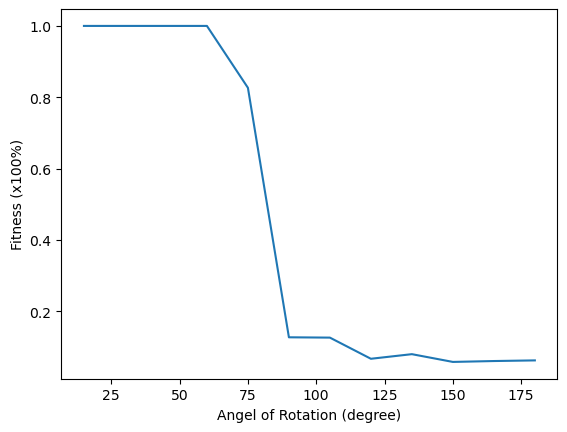

In [100]:
plt.plot(rotate_angle_degree, fitness_res_rotate)
plt.xlabel('Angel of Rotation (degree)')
plt.ylabel('Fitness (x100%)')
plt.show()

## Part 3

In [ ]:
def perturb_and_save(mesh_fp, sigma, mesh_save_fp):
    # about z-axis
    ply = o3d.io.read_triangle_mesh(mesh_fp)
    points = np.asarray(ply.vertices)
    noises = np.random.normal(0, sigma, points.shape)
    ply.vertices = o3d.utility.Vector3dVector(points + noises)
    o3d.io.write_triangle_mesh(mesh_save_fp, ply)

In [157]:
mesh_dir_fp = 'bunny_v2'
mesh1_fn = 'bun000_v2.ply'
mesh2_origin_fn = 'bun045_v2.ply'

mesh2_fp = os.path.join(mesh_dir_fp, mesh2_origin_fn)
ply2 = o3d.io.read_triangle_mesh(mesh2_fp)
aabb = ply2.get_axis_aligned_bounding_box()
xl_aabb, yl_aabb, zl_aabb = np.asarray(aabb.get_extent())
print(xl_aabb, yl_aabb, zl_aabb)
noise_sigmas_rate = np.array([1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 6e-3, 7e-3, 8e-3, 9e-3,
                              1e-2, 2e-2, 3e-2, 4e-2, 5e-2, 6e-2, 7e-2, 8e-2, 9e-2,
                              1e-1, 3e-1, 5e-1])
noise_sigmas = np.vstack((xl_aabb * noise_sigmas_rate,
                          yl_aabb * noise_sigmas_rate,
                          zl_aabb * noise_sigmas_rate)).T

0.14725 0.1534299 0.1386886


In [158]:
log_noise_sigmas = np.log10(noise_sigmas_rate)
fitness_res_perturb = np.zeros(noise_sigmas_rate.shape)
fitness_res_perturb_with_sigma = np.zeros(noise_sigmas_rate.shape)

for i, sigma in enumerate(noise_sigmas):
    mesh_after_perturb = 'bun045_v2_perturb_%.6f.ply' % noise_sigmas_rate[i]
    mesh1_fp = os.path.join(mesh_dir_fp, mesh1_fn)
    mesh2_fp = os.path.join(mesh_dir_fp, mesh2_origin_fn)
    mesh2_perturb_fp = os.path.join(mesh_dir_fp, mesh_after_perturb)
    perturb_and_save(mesh2_fp, sigma, mesh2_perturb_fp)
    print('Noise rate: %.6f' % noise_sigmas_rate[i])
    ply1, ply2 = icp(mesh1_fp, mesh2_perturb_fp)
    evaluation = evaluate_align(ply2, ply1)
    evaluation_with_sigma = evaluate_align(ply2, ply1, threshold=1e-3+np.linalg.norm(sigma))
    o3d.io.write_triangle_mesh(os.path.join(mesh_dir_fp, 'bun045_v2_perturb_%.6f_reg.ply' % noise_sigmas_rate[i]), ply2)
    fitness_res_perturb[i] = evaluation.fitness
    fitness_res_perturb_with_sigma[i] = evaluation_with_sigma.fitness
    # print(evaluation)
    # show_mesh([ply1, ply2])

Noise rate: 0.001000
Possible to be aligned after 61 iteration(s).
Noise rate: 0.002000
Possible to be aligned after 68 iteration(s).
Noise rate: 0.003000
Possible to be aligned after 65 iteration(s).
Noise rate: 0.004000
Possible to be aligned after 78 iteration(s).
Noise rate: 0.005000
Possible to be aligned after 65 iteration(s).
Noise rate: 0.006000
Possible to be aligned after 67 iteration(s).
Noise rate: 0.007000
Possible to be aligned after 74 iteration(s).
Noise rate: 0.008000
Possible to be aligned after 73 iteration(s).
Noise rate: 0.009000
Possible to be aligned after 73 iteration(s).
Noise rate: 0.010000
Possible to be aligned after 80 iteration(s).
Noise rate: 0.020000
Possible to be aligned after 79 iteration(s).
Noise rate: 0.030000
Possible to be aligned after 68 iteration(s).
Noise rate: 0.040000
Possible to be aligned after 96 iteration(s).
Noise rate: 0.050000
Possible to be aligned after 77 iteration(s).
Noise rate: 0.060000
Possible to be aligned after 78 iteration

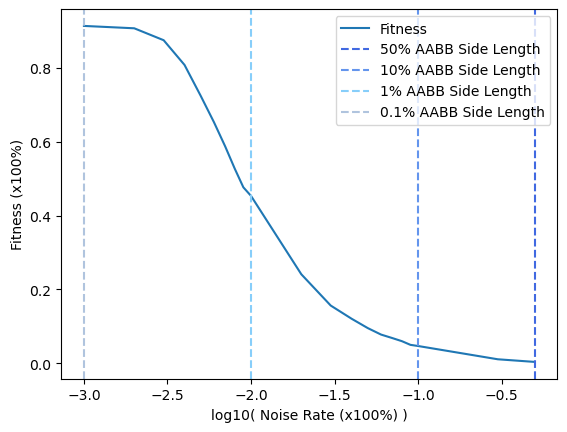

In [159]:
plt.plot(np.log10(noise_sigmas_rate), fitness_res_perturb, label='Fitness')
plt.axvline(np.log10(5e-1), c='royalblue', linestyle='--', label='50% AABB Side Length')
plt.axvline(np.log10(1e-1), c='cornflowerblue', linestyle='--', label='10% AABB Side Length')
plt.axvline(np.log10(1e-2), c='lightskyblue', linestyle='--', label='1% AABB Side Length')
plt.axvline(np.log10(1e-3), c='lightsteelblue', linestyle='--', label='0.1% AABB Side Length')
plt.xlabel('log10( Noise Rate (x100%) )')
plt.ylabel('Fitness (x100%)')
plt.legend()
plt.show()

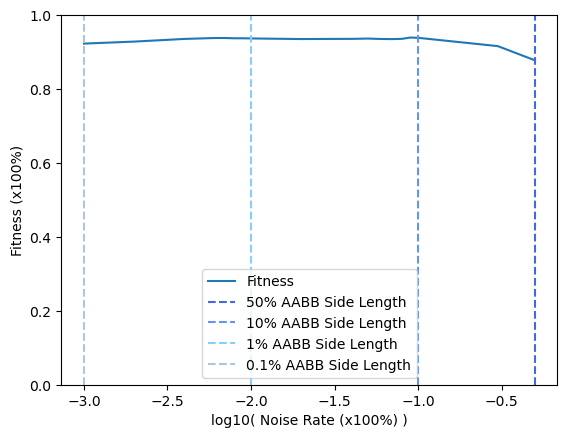

In [162]:
plt.plot(np.log10(noise_sigmas_rate), fitness_res_perturb_with_sigma, label='Fitness')
plt.axvline(np.log10(5e-1), c='royalblue', linestyle='--', label='50% AABB Side Length')
plt.axvline(np.log10(1e-1), c='cornflowerblue', linestyle='--', label='10% AABB Side Length')
plt.axvline(np.log10(1e-2), c='lightskyblue', linestyle='--', label='1% AABB Side Length')
plt.axvline(np.log10(1e-3), c='lightsteelblue', linestyle='--', label='0.1% AABB Side Length')
plt.xlabel('log10( Noise Rate (x100%) )')
plt.ylabel('Fitness (x100%)')
plt.ylim(0, 1)
plt.legend()
plt.show()

## Part 4

In [42]:
mesh1_fp = os.path.join('bunny_v2', 'bun000_v2.ply')
mesh2_fp = os.path.join('bunny_v2', 'bun045_v2.ply')

ply2 = o3d.io.read_triangle_mesh(mesh2_fp)
points2 = np.asarray(ply2.vertices)
pts2_number = points2.shape[0]
sample_numbers = (np.array([1e-4, 2e-4, 4e-4, 6e-4, 8e-4,
                            1e-3, 2e-3, 4e-3, 6e-3, 8e-3,
                            1e-2, 2e-2, 4e-2, 6e-2, 8e-2,
                            1e-1, 3e-1, 5e-1, 1]) * pts2_number).astype(np.int64)
log_sample_rates = np.log10(sample_numbers / pts2_number)
fitness_res_sample = np.zeros(sample_numbers.shape)
time_costs = np.zeros(sample_numbers.shape)
for i, sample_number in enumerate(sample_numbers):
    print("Sample number: %d." % sample_number)
    start = time.time()
    ply1, ply2 = icp(mesh1_fp, mesh2_fp, 1e-3, None, 300, sample_number)
    time_cost = time.time() - start
    evaluation = evaluate_align(ply2, ply1)
    fitness_res_sample[i] = evaluation.fitness
    time_costs[i] = time_cost
    # print(evaluation)
    # show_mesh([ply1, ply2])

Sample number: 4.
Possible to be aligned after 263 iteration(s).
Sample number: 8.
Possible to be aligned after 75 iteration(s).
Sample number: 16.
Possible to be aligned after 132 iteration(s).
Sample number: 24.
Possible to be aligned after 60 iteration(s).
Sample number: 32.
Possible to be aligned after 48 iteration(s).
Sample number: 40.
Possible to be aligned after 89 iteration(s).
Sample number: 80.
Possible to be aligned after 67 iteration(s).
Sample number: 160.
Possible to be aligned after 65 iteration(s).
Sample number: 240.
Possible to be aligned after 61 iteration(s).
Sample number: 320.
Possible to be aligned after 71 iteration(s).
Sample number: 400.
Possible to be aligned after 69 iteration(s).
Sample number: 801.
Possible to be aligned after 61 iteration(s).
Sample number: 1603.
Possible to be aligned after 60 iteration(s).
Sample number: 2405.
Possible to be aligned after 55 iteration(s).
Sample number: 3207.
Possible to be aligned after 60 iteration(s).
Sample number:

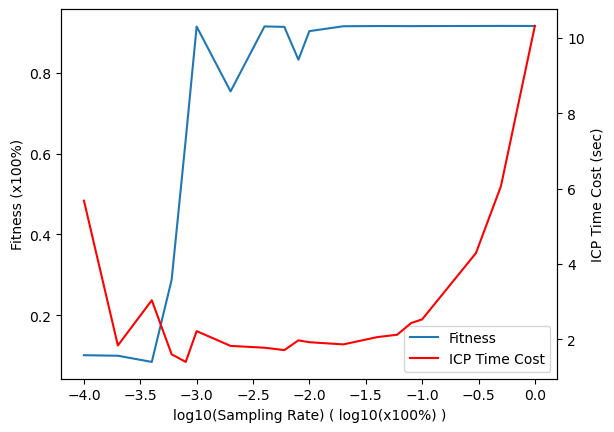

In [163]:
fig = plt.figure()
ax1 = fig.add_subplot()
ln1 = ax1.plot(log_sample_rates, fitness_res_sample, label='Fitness')
ax1.set_xlabel('log10(Sampling Rate) ( log10(x100%) )')
ax1.set_ylabel('Fitness (x100%)')

ax2 = ax1.twinx()
ln2 = ax2.plot(log_sample_rates, time_costs, 'r', label='ICP Time Cost')
ax2.set_ylabel('ICP Time Cost (sec)')

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.show()

## Part 5

In [44]:
def convert_pts_to_ptc(pts):
    pts_o3d = o3d.geometry.PointCloud()
    pts_o3d.points = o3d.utility.Vector3dVector(pts)
    return pts_o3d

In [45]:
def preprocess_point_cloud(pcd_down, voxel_size):
    radius_normal = voxel_size * 2
    pcd_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
    radius_feature = voxel_size * 5
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(pcd_down, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_fpfh

In [46]:
def prepare_dataset(voxel_size, mesh1_fp, mesh2_fp):
    ply1 = o3d.io.read_triangle_mesh(mesh1_fp)
    ply2 = o3d.io.read_triangle_mesh(mesh2_fp)
    source_down = convert_pts_to_ptc(uniform_sample(ply2, 10000))
    target_down = convert_pts_to_ptc(uniform_sample(ply1, 10000))

    source_fpfh = preprocess_point_cloud(source_down, voxel_size)
    target_fpfh = preprocess_point_cloud(target_down, voxel_size)
    return source_down, target_down, source_fpfh, target_fpfh

In [47]:
def execute_fast_global_registration(source_down, target_down, source_fpfh,
                                     target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.5
    result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result

In [48]:
mesh1_fp = os.path.join('bunny_v2', 'bun000_v2.ply')
mesh2_fp = os.path.join('bunny_v2', 'bun315_v2.ply')
voxel_size = 0.005
source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(voxel_size, mesh1_fp, mesh2_fp)
result = execute_fast_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)
print(result.transformation)

[[ 7.12692393e-01 -1.52033020e-02 -7.01311923e-01 -7.05879404e-03]
 [ 2.13932620e-02  9.99771136e-01  6.70066639e-05  1.64328023e-04]
 [ 7.01150399e-01 -1.50511049e-02  7.12854531e-01 -1.30549188e-02]
 [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00  1.00000000e+00]]


In [49]:
ply1, ply2 = icp(mesh1_fp, mesh2_fp, 5e-4, result.transformation)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun000_v2_paint315.ply'), ply1)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun315_v2_reg_paint.ply'), ply2)
evaluation = evaluate_align(ply2, ply1)
print(evaluation)
# show_mesh([ply1, ply2])

Possible to be aligned after 8 iteration(s).
RegistrationResult with fitness=7.966946e-01, inlier_rmse=4.022187e-04, and correspondence_set size of 28152
Access transformation to get result.


In [211]:
mesh_dir_fp = 'bunny_v2'
meshs_fn = ['bun000_v2.ply', 'bun045_v2.ply', 'bun000_v2_rotate_z_180.ply', 'bun270_v2.ply', 'bun315_v2.ply']
voxel_sizes = [0., 1e-4, 1e-4, 1e-4, 1e-4]
base_mesh_fn = meshs_fn[0]
base_mesh_fn_no_sfx = meshs_fn[0].split('.')[0]
for mesh_fn, voxel_size in zip(meshs_fn[1:], voxel_sizes[1:]):
    mesh1_fp = os.path.join(mesh_dir_fp, base_mesh_fn)
    mesh2_fp = os.path.join(mesh_dir_fp, mesh_fn)
    print('Aligning ' + mesh_fn + ' to ' + base_mesh_fn + '.')
    voxel_size = 0.005
    source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(voxel_size, mesh1_fp, mesh2_fp)
    result = execute_fast_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)
    # print(result.transformation)
    ply1, ply2 = icp(mesh1_fp, mesh2_fp, 5e-4, result.transformation)
    mesh_fn_no_sfx = mesh_fn.split('.')[0]
    o3d.io.write_triangle_mesh(os.path.join(mesh_dir_fp, base_mesh_fn_no_sfx + '_paint_' + mesh_fn_no_sfx + '.ply'), ply1)
    o3d.io.write_triangle_mesh(os.path.join(mesh_dir_fp, mesh_fn_no_sfx + '_reg_' + base_mesh_fn_no_sfx + '.ply'), ply2)
    evaluation = evaluate_align(ply2, ply1)
    print(evaluation)
    # show_mesh([ply1, ply2])

Aligning bun045_v2.ply to bun000_v2.ply.
Possible to be aligned after 3 iteration(s).
RegistrationResult with fitness=9.154301e-01, inlier_rmse=3.706026e-04, and correspondence_set size of 36706
Access transformation to get result.
Aligning bun000_v2_rotate_z_180.ply to bun000_v2.ply.
Possible to be aligned after 2 iteration(s).
RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.517907e-04, and correspondence_set size of 40256
Access transformation to get result.
Aligning bun270_v2.ply to bun000_v2.ply.
Possible to be aligned after 102 iteration(s).
RegistrationResult with fitness=2.228321e-01, inlier_rmse=6.441702e-04, and correspondence_set size of 7064
Access transformation to get result.
Aligning bun315_v2.ply to bun000_v2.ply.
Possible to be aligned after 8 iteration(s).
RegistrationResult with fitness=7.970059e-01, inlier_rmse=4.133960e-04, and correspondence_set size of 28163
Access transformation to get result.


## Part 6

In [50]:
def ptpl_match_points(sampled_pts, mesh_pts, n):
    n_pts, dim = sampled_pts.shape
    tree = KDTree(mesh_pts, leaf_size=2)
    dist, idx = tree.query(sampled_pts, k=1)
    return dist.reshape((n_pts,)), mesh_pts[idx].reshape((n_pts, dim)), n[idx].reshape((n_pts, dim))

In [51]:
def ptpl_reject_pairs(p, q, dist, n):
    med = np.median(dist)
    idx = np.where(dist < 2. * med)
    return p[idx], q[idx], n[idx]

In [187]:
def ptpl_solve_Rt(p, q, n_p):
    a = np.cross(q, n_p)
    A = np.hstack((a, n_p))
    b = np.sum(n_p * p - n_p * q, axis=1)
    
    u, s, vh = np.linalg.svd(A, full_matrices=False)
    Aplus = vh.T @ np.linalg.pinv(np.diag(s)) @ u.T
    # x = (np.linalg.pinv(A.T @ A) @ A.T @ b).reshape((6,))
    alpha, beta, gamma, tx, ty, tz = b @ Aplus.T

    r11 = np.cos(gamma) * np.cos(beta)
    r12 = -np.sin(gamma) * np.cos(alpha) + np.cos(gamma) * np.sin(beta) * np.sin(alpha)
    r13 = np.sin(gamma) * np.sin(alpha) + np.cos(gamma) * np.sin(beta) * np.cos(alpha) 
    r21 = np.sin(gamma) * np.cos(beta)
    r22 = np.cos(gamma) * np.cos(alpha) + np.sin(gamma) * np.sin(beta) * np.sin(alpha)
    r23 = -np.cos(gamma) * np.sin(alpha) + np.sin(gamma) * np.sin(beta) * np.cos(alpha)
    r31 = -np.sin(beta)
    r32 = np.cos(beta) * np.sin(alpha)
    r33 = np.cos(beta) * np.cos(alpha)

    R = np.array([
        [r11, r12, r13],
        [r21, r22, r23],
        [r31, r32, r33]
    ])
    t = np.array([tx, ty, tz])
    return R, t

In [214]:
def ptpl_icp(mesh1_fp, mesh2_fp, tl=1e-3, max_it=300):
    # mesh2 to mesh1

    ply1 = o3d.io.read_triangle_mesh(mesh1_fp)
    ply2 = o3d.io.read_triangle_mesh(mesh2_fp)

    ply1 = ply1.compute_vertex_normals()
    n_p = np.asarray(ply1.vertex_normals)

    E = np.array([
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
    ])
    
    cnt_it = 0
    while cnt_it < max_it:
    
        points1 = np.asarray(ply1.vertices)
        sampled_points2 = uniform_sample(ply2)
        
        dist, corr_points1, n = ptpl_match_points(sampled_points2, points1, n_p)
        p, q, n = ptpl_reject_pairs(corr_points1, sampled_points2, dist, n_p)
        R, t = ptpl_solve_Rt(p, q, n)

        if np.linalg.norm(E - R) < tl:
            ply1, ply2 = paint_overlap(ply1, ply2)
            print("Possible to be aligned after %d iteration(s)." % cnt_it)
            return ply1, ply2

        cnt_it += 1
        ply2 = ply2.rotate(R)
        ply2 = ply2.translate(t)

    ply1, ply2 = paint_overlap(ply1, ply2)
    print("ICP stopped after max iteration number %d." % max_it)
    return ply1, ply2

In [212]:
mesh1_fp = os.path.join('bunny_v2', 'bun000_v2.ply')
ply1 = o3d.io.read_triangle_mesh(mesh1_fp)
ply1 = ply1.compute_vertex_normals()
ns = np.asarray(ply1.vertex_normals)
ns = (ns + 1) / 2.
ply1.vertex_colors = o3d.utility.Vector3dVector(ns)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun000_v2_paint_normal.ply'), ply1)
# show_mesh([ply1])

True

In [215]:
mesh1_fp = os.path.join('bunny_v2', 'bun000_v2.ply')
mesh2_fp = os.path.join('bunny_v2', 'bun045_v2.ply')
ply1, ply2 = ptpl_icp(mesh1_fp, mesh2_fp, 1e-4)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun000_v2_ptpl_paint045.ply'), ply1)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun045_v2_ptpl_reg_paint.ply'), ply2)
evaluation = evaluate_align(ply2, ply1)
print(evaluation)
# show_mesh([ply1, ply2])

ICP stopped after max iteration number 300.
RegistrationResult with fitness=9.122628e-01, inlier_rmse=3.890411e-04, and correspondence_set size of 36579
Access transformation to get result.
